# Pipeline

1. Preprocessing
2. Cosine Similarity / Nearest Neighbors
3. Build / Test Models

## 1. Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

In [2]:
db_path = '../data/beer.db'
conn = sqlite3.connect(db_path)

query = "SELECT * FROM user_extract"
df = pd.read_sql(query, conn)

In [3]:
# 1. remove duplicates 
df = df[~df.duplicated()]

In [4]:
# 2. one-hot encode categorical variables
categorical_variables = ['beer_description', 'brewery']
for cat_var in categorical_variables:
    dummies = pd.get_dummies(df[cat_var], drop_first=True, prefix=cat_var)
    df = pd.merge(df, dummies, left_index=True, right_index=True)

In [5]:
# 4. flag outliers
features = ['ABV', 'global_rating', 'user_rating', 'IBU']
skipnas = True

for feature in features:
    try:
        q1 = df[feature].quantile(.25)
        q3 = df[feature].quantile(.75)
        iqr = q3 - q1
        non_outlier_mask = (df[feature] >= q1 - 1.5*iqr) & (df[feature] <= q3 + 1.5*iqr)
        outliers = df[~non_outlier_mask]

        print("FEATURE {}".format(feature))
        print("num of outliers = {:,d}".format(len(outliers)))
        print("% of outliers = {:.2f}%".format(100*len(outliers)/len(df)))
        print("\n")
    except TypeError:
        print("FEATURE {}".format(feature))
        print("ANALYZING ALL NON-NA VALUES")
        
        non_nas = df[~df[feature].isna()][feature].astype(float)
        q1 = non_nas.quantile(.25)
        q3 = non_nas.quantile(.75)
        iqr = q3 - q1
        non_outlier_mask = (non_nas >= q1 - 1.5*iqr) & (non_nas <= q3 + 1.5*iqr)
        outliers = non_nas[~non_outlier_mask]
        print("num of outliers = {:,d}".format(len(outliers)))
        print("% of outliers = {:.2f}%".format(100*len(outliers)/len(non_nas)))
        print("\n")

FEATURE ABV
num of outliers = 3,421
% of outliers = 3.33%


FEATURE global_rating
num of outliers = 3,648
% of outliers = 3.56%


FEATURE user_rating
num of outliers = 11,267
% of outliers = 10.98%


FEATURE IBU
ANALYZING ALL NON-NA VALUES
num of outliers = 557
% of outliers = 1.00%




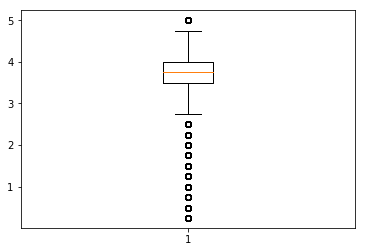

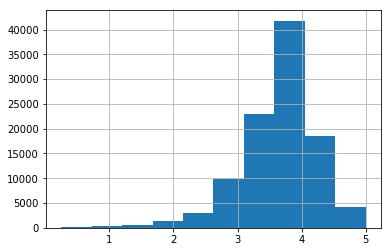

In [21]:
plt.boxplot(df['user_rating'])
plt.show()
df['user_rating'].hist()

In [6]:
# 4. Impute missing values 
features = ['ABV', 'global_rating', 'user_rating', 'IBU']
impute_method = 'mean'

for feature in features:
    if impute_method == 'mean':
        non_nas = df[~df[feature].isna()][feature].astype(float)
        feature_mean = non_nas.mean()
        df[feature] = df[feature].fillna(feature_mean)

## 2. Cosine Similarity / Nearest Neighbors

In [7]:
# 1. Create User-Item Matrix 
fill_method = 'item_mean'

data = df
values = 'user_rating'
index = 'username'
columns = 'beer_name'
agg_func = 'mean'

if fill_method == 'item_mean':
    ui_matrix = pd.pivot_table(data=data, values=values, index=index, 
                               columns=columns, aggfunc=agg_func)
    ui_matrix = ui_matrix.fillna(ui_matrix.mean(axis=0), axis=0)

elif fill_method == 'user_mean':
    ui_matrix = pd.pivot_table(data=data, values=values, index=index, 
                               columns=columns, aggfunc=agg_func)
    ui_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)

elif fill_method == 0:
    ui_matrix = pd.pivot_table(data=data, values=values, index=index, 
                               columns=columns, aggfunc=agg_func, fill_value=0)
else:
    raise ValueError("Please checkout 'fill_method' value")

ui_matrix.columns = list(ui_matrix.columns)

In [8]:
# 2. Scale / Standardize 
scale_standardize = 'standardize'

if scale_standardize == 'scale':
    print('Data is already scaled from 0 to 5')
elif scale_standardize == 'standardize':
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    standardized_ui_matrix = pd.DataFrame(scaler.fit_transform(ui_matrix))
    standardized_ui_matrix.index = ui_matrix.index
    standardized_ui_matrix.columns = ui_matrix.columns
    ui_matrix = standardized_ui_matrix
elif scale_standardize == None:
    print("Skipping scaling / standardization")
else:
    raise ValueError("Please checkout 'scale_standardize' value")

In [22]:
# Calculate Cosine Similarity 
user_of_reference = 'tsharp93'
print("User of Reference for Cosine Sim = {}".format(user_of_reference))

from sklearn.metrics.pairwise import cosine_similarity
X = ui_matrix[ui_matrix.index == user_of_reference]
Y = ui_matrix[ui_matrix.index != user_of_reference]

sim = cosine_similarity(X,Y)[0].tolist()
names = Y.index

sim_df = pd.DataFrame({'username':names, 'sim_score':sim})
sim_df = sim_df.sort_values(by='sim_score', ascending=False)

User of Reference for Cosine Sim = tsharp93


In [23]:
sim_df.head()

,username,sim_score
18,Gmlman,0.857681
34,Mikeylga,0.856230
39,MythicMan57,0.845642
94,junana71,0.842739
98,kwitnes,0.840310


## 3. Build Models

In [31]:
brewery_cols = [col for col in df if col.startswith('brewery_')]
beer_description_cols = [col for col in df if col.startswith('beer_description_')]

features = ['ABV', 'IBU', 'global_rating'] + beer_description_cols
target = 'user_rating'

target_user = 'tsharp93'
print("Target User = {}".format(target_user))

X_train = df[df['username'] == target_user][features]
X_test = df[df['username'] != target_user][features]
y_train = df[df['username'] == target_user][target]
y_test = df[df['username'] != target_user][target]

Target User = tsharp93


In [89]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet

estimator_dict = {}

# create models and grids 
estimator = LinearRegression()
grid = {}
estimator_dict['linearregression'] = {'estimator':estimator, 'grid':grid}


estimator = Lasso()
grid = {
    'alpha': np.linspace(0.1, 1.0, 5),
    'fit_intercept': [True, False]
}
estimator_dict['lasso'] = {'estimator':estimator, 'grid':grid}

estimator = ElasticNet()
grid = {
    'alpha': np.linspace(0.1, 1.0, 5),
    'l1_ratio': np.linspace(0.1, 1.0, 5),
    'fit_intercept': [True, False]
}
estimator_dict['elasticnet'] = {'estimator':estimator, 'grid':grid}


for key in estimator_dict.keys():
    gridsearchcv = GridSearchCV(estimator = estimator_dict[key]['estimator'], 
                                param_grid = estimator_dict[key]['grid'],
                                cv=3, scoring='neg_mean_squared_error', return_train_score=True, iid=True)
    
    gridsearchcv.fit(X_train, y_train)
    
    estimator_dict[key]['best_params'] = gridsearchcv.best_params_
    estimator_dict[key]['best_score'] = gridsearchcv.best_score_

In [86]:
estimator_dict

dict_keys(['linearregression', 'lasso', 'elasticnet'])

In [91]:
pd.DataFrame.from_dict(estimator_dict, orient='index')

,estimator,grid,best_params,best_score
elasticnet,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...","{'alpha': [0.1, 0.325, 0.55, 0.775, 1.0], 'l1_...","{'alpha': 0.325, 'fit_intercept': True, 'l1_ra...",-1.855227e-01
lasso,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","{'alpha': [0.1, 0.325, 0.55, 0.775, 1.0], 'fit...","{'alpha': 0.1, 'fit_intercept': True}",-1.898285e-01
linearregression,"LinearRegression(copy_X=True, fit_intercept=Tr...",{},{},-3.474628e+21
